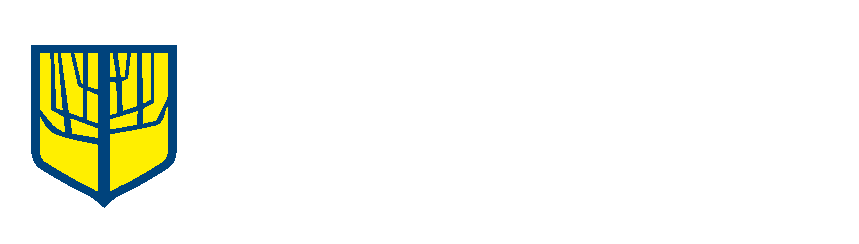

**Universidad Sergio Arboleda**

*Programa Ciencias de la Computación e Inteligencia Artificial*

*Autor: Laura Ojeda - Daniel Velásquez*

*Fecha: Marzo 2024*

*Tópico: Proyecto Visualizacion ECG*

*Materia: Introducción a Bioingenieria*


# Bibliotecas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Serie de Fourier para media onda

In [ ]:
# Definir la función de la serie de Fourier para media onda
def half_wave_fourier_series(x, y, n_terms):
    series = np.zeros_like(y)
    for n in range(1, n_terms + 1):
        if n % 2 != 0:
            coef = (4 / (np.pi * n))
            series += coef * np.sin(2 * np.pi * n * x)
    return series

In [ ]:
# Funcion para generar la serie de fourier para media onda
def gen_serfou_media(x, y, num_terms):
  # Número de términos en la serie de Fourier
  n_terms = num_terms

  # Generar la serie de Fourier para media onda
  fourier_series = half_wave_fourier_series(x, y, n_terms)

  # Graficar la señal original y la serie de Fourier
  plt.figure(figsize=(10, 6))
  plt.plot(x, y, label='Señal original')
  plt.plot(x, fourier_series, label=f'Serie de Fourier para media onda (Términos={n_terms})')
  plt.xlabel('Tiempo')
  plt.ylabel('Amplitud')
  plt.title('Serie de Fourier para media onda')
  plt.grid(True)
  plt.legend()
  plt.show()

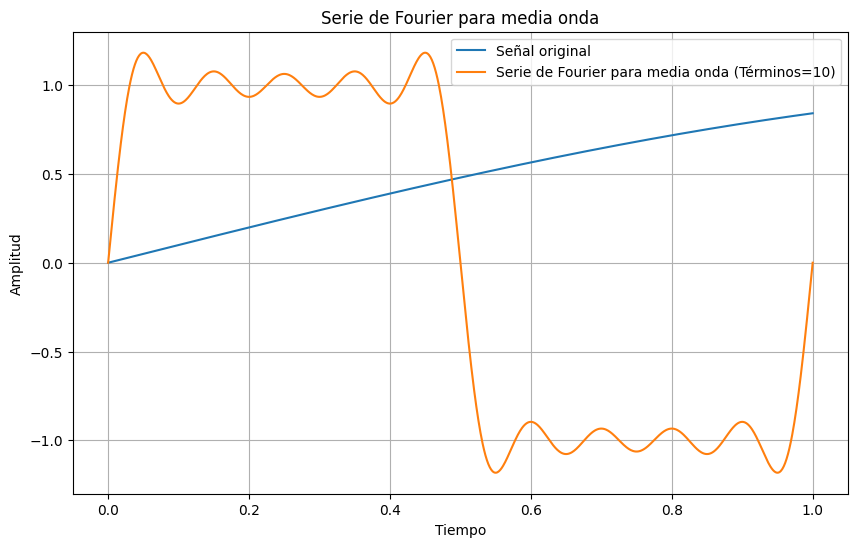

In [ ]:
# Limite en x = 1
lim = 1
# Numero de terminos de la serie de fourier = 10
num_terms = 10
x = np.linspace(0, lim, 1000)
y = np.sin(x)

gen_serfou_media(x, y, num_terms)

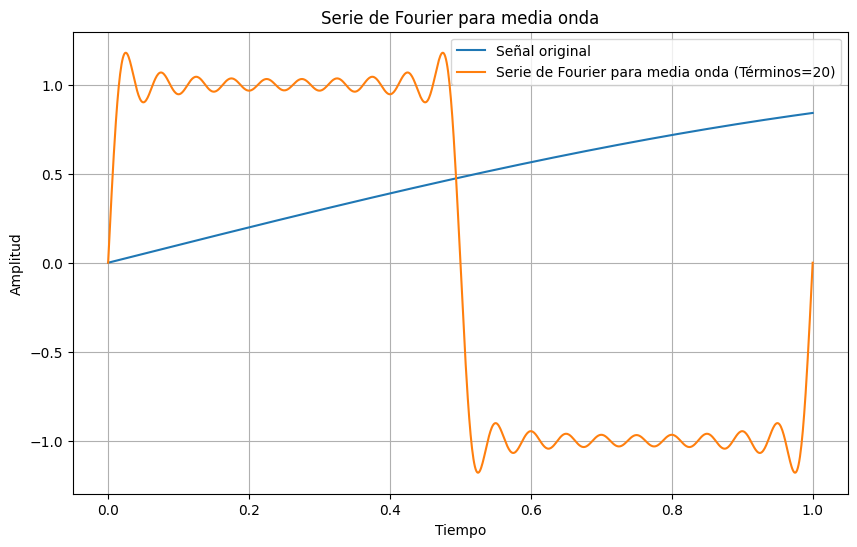

In [ ]:
# Limite en x = 1
lim = 1
# Numero de terminos de la serie de fourier = 20
num_terms = 20
x = np.linspace(0, lim, 1000)
y = np.sin(x)

gen_serfou_media(x, y, num_terms)

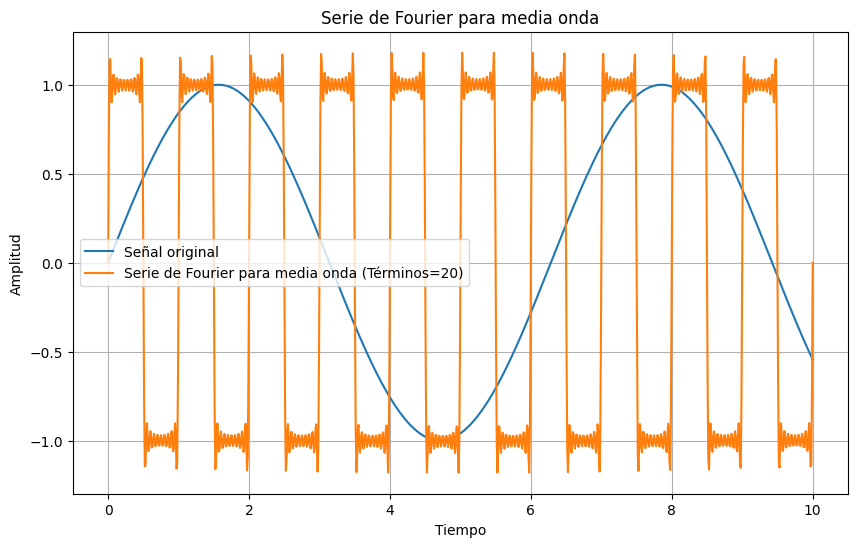

In [ ]:
# Limite en x = 10
lim = 10
# Numero de terminos de la serie de fourier = 20
num_terms = 20
x = np.linspace(0, lim, 1000)
y = np.sin(x)

gen_serfou_media(x, y, num_terms)

# Diseño de ECG persona sana

## Generacion por medio de CSV

Diseño de señal ECG a base de archivos CSV proporcionados por la docente

### Importación de Datos

In [ ]:
# URL del archivo CSV
url = "https://raw.githubusercontent.com/danieeeel11/Datasets/main/bioingenieria/ECG.csv"

# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv(url, names=['x','y'])

In [ ]:
# Mostrar el dataset importado
df

,x,y
0,"-3,69E-04","-9,43E-03"
1,"-3,68E-04","-9,43E-03"
2,"-3,68E-04","-9,43E-03"
3,"-3,67E-04","-9,43E-03"
4,"-3,67E-04","-9,43E-03"
...,...,...
1950,"6,29E-04","-9,43E-03"
1951,"6,29E-04","-1,35E-02"
1952,"6,30E-04","-9,43E-03"
1953,"6,30E-04","-9,43E-03"


### Limpieza de Datos

Se debe realizar una limpieza de datos al dataset importado, dado que los valores que se encuentran valores numericos decimales con "E" haciendo alusion a la expresion de notacion cientifica de decimales.

Sin embargo, alprocesar los datos, no se evalua correctamente esta notacion debido a que para el contexto programable, se representa a la notación cientifica con la letra "e" minuscula.

Para esto, la limpieza de datos consiste en transformar en los valores del Dataset aquellos valores que contengan una letra "E", en "e", para que al momento de procesar la información se consignen esos valores como float y su interpretación de notacion cientifica sea correcta.

In [ ]:
# Reemplazar comas por puntos y convertir notación científica a float
df['x'] = df['x'].str.replace(',', '.').apply(lambda x: float(x.replace('E', 'e')))
df['y'] = df['y'].str.replace(',', '.').apply(lambda x: float(x.replace('E', 'e')))

In [ ]:
# Verificar los tipos de datos después de la conversión
print(df.dtypes)

x    float64
y    float64
dtype: object


In [ ]:
# Mostrar el dataset actualizado
df

,x,y
0,-0.000369,-0.00943
1,-0.000368,-0.00943
2,-0.000368,-0.00943
3,-0.000367,-0.00943
4,-0.000367,-0.00943
...,...,...
1950,0.000629,-0.00943
1951,0.000629,-0.01350
1952,0.000630,-0.00943
1953,0.000630,-0.00943


### Grafica inicial



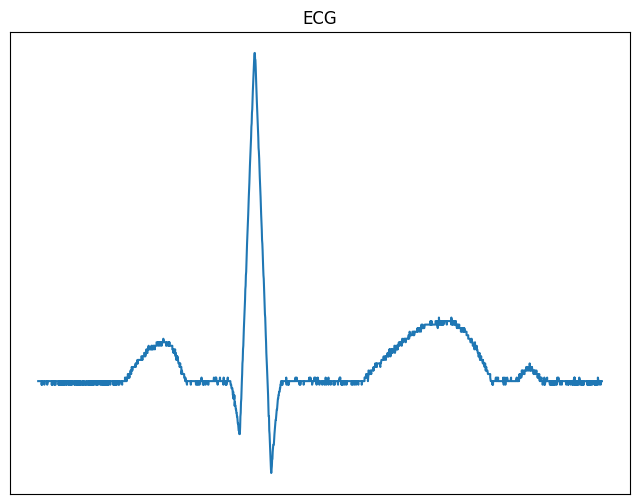

In [ ]:
# Establecer el tamaño de la figura
plt.figure(figsize=(8, 6))

# Crear la figura de puntos
plt.plot(df['x'], df['y'])
plt.xticks([])
plt.yticks([])
plt.title('ECG')

# Mostrar la figura
plt.show()

### Grafica ampliada

#### Metodo 1 - Ampliación por repeticion de señal original

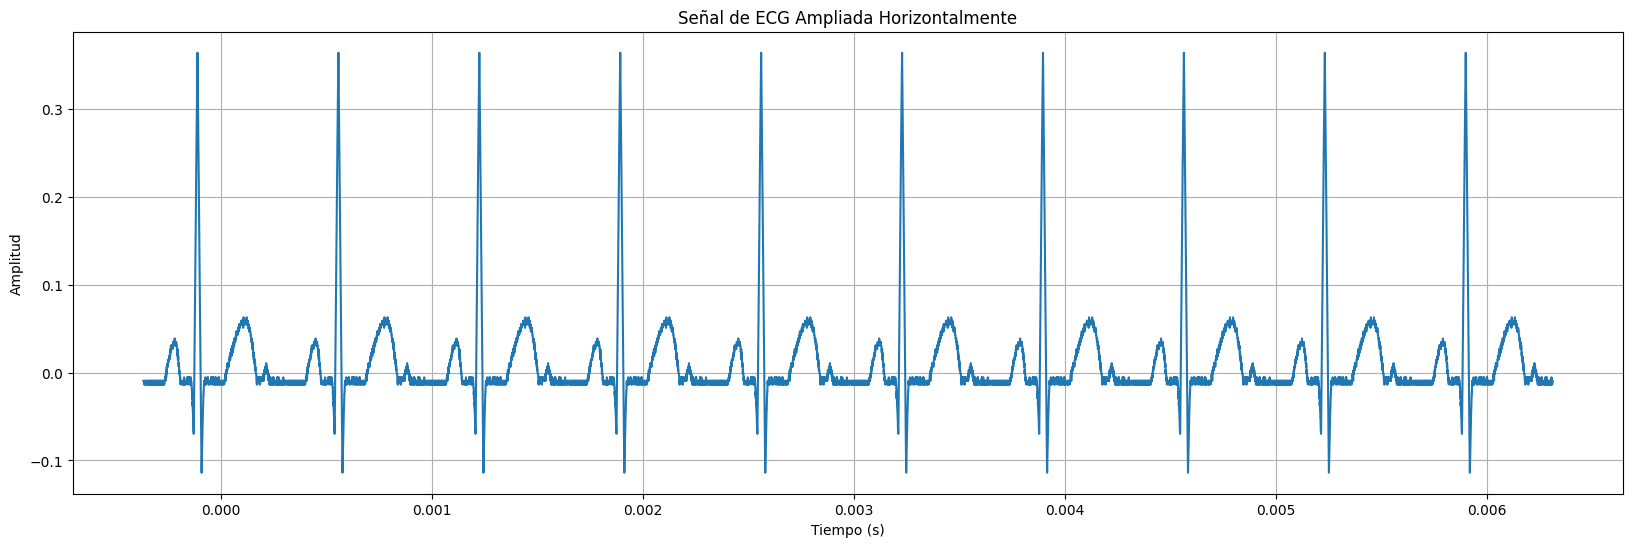

In [ ]:
# Ampliar la gráfica horizontalmente
repeticiones = 10  # Factor de ampliación horizontal
x_ampliado = np.linspace(min(df['x']), max(df['x']) * repeticiones, len(df['x']) * repeticiones)
y_ampliado = np.tile(df['y'], repeticiones)

# Dibujar la señal ECG ampliada
plt.figure(figsize=(20, 6))
plt.plot(x_ampliado, y_ampliado)
plt.title('Señal de ECG Ampliada Horizontalmente')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

#### Metodo 2 - Ampliacion por reconstruccion de series de fourier

In [ ]:
# Funcion para obtener los coeficientes de la serie de Fourier
def coeficientes_serie_fourier(x, y, num_terms):
    N = len(x)
    L = x[-1] - x[0]
    a_0 = np.mean(y)
    a_n = []
    b_n = []

    for n in range(1, num_terms + 1):
        a_n.append(2/N * np.sum(y * np.cos(2 * np.pi * n * x / L)))
        b_n.append(2/N * np.sum(y * np.sin(2 * np.pi * n * x / L)))

    return a_0, np.array(a_n), np.array(b_n)

# Funcion para reconstruir la señal original ahora ampliada
def senal_reconstruida(x, a_0, a_n, b_n, L):
    f_x = a_0
    for n in range(1, len(a_n) + 1):
        f_x += a_n[n - 1] * np.cos(2 * np.pi * n * x / L) + b_n[n - 1] * np.sin(2 * np.pi * n * x / L)
    return f_x

##### Reconstruccion de la señal original

In [ ]:
x_val = df['x'].values
y_val = df['y'].values

a_0, a_n, b_n = coeficientes_serie_fourier(x_val, y_val, 100)
signal_recons = senal_reconstruida(x_val, a_0, a_n, b_n, x_val[-1] - x_val[0])

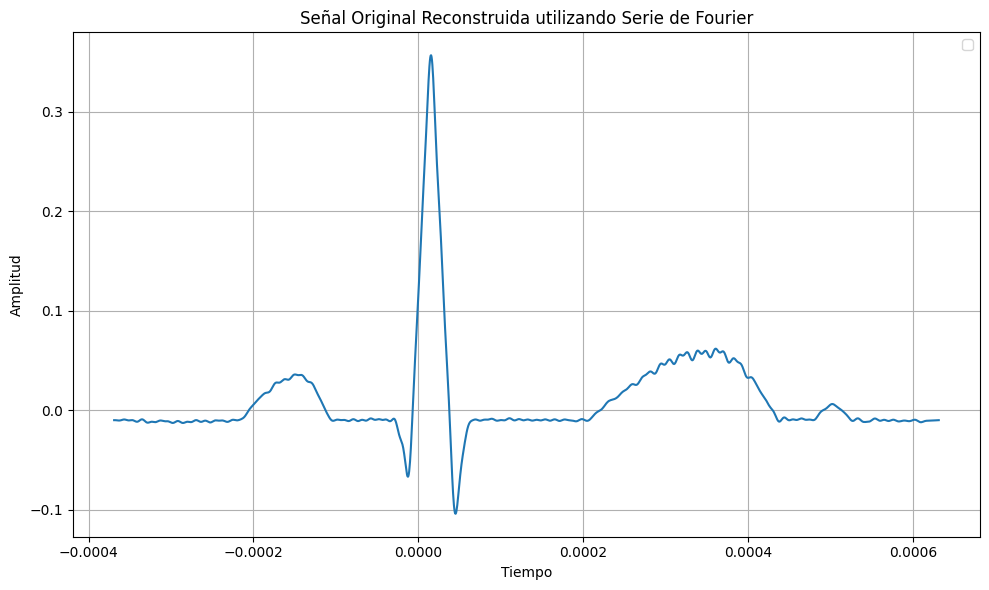

In [ ]:
# Graficar la señal reconstruida
plt.figure(figsize=(10, 6))
plt.plot(x_val, signal_recons)
plt.title('Señal Original Reconstruida utilizando Serie de Fourier')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### Reconstruccion de la señal original y ampliada



In [ ]:
x_val = np.linspace(df['x'].min(), df['x'].max(), 10000)
# Se obtienen los coeficientes de la serie de fourier de la señal original
a_0, a_n, b_n = coeficientes_serie_fourier(df['x'].values, df['y'].values, 100)
# Obtenemos la funcion original reconstruida
funcion_original_recon = senal_reconstruida(x_val, a_0, a_n, b_n, x_val[-1] - x_val[0])
# Establecemos la cantidad de puntos que queremos ampliar
num_apliados = 90000
# Obtenemos el periodo original, es decir, la seccion de tiempo de nuestra señal original
periodo_original = x_val[-1] - x_val[0]

In [ ]:
# Obtenemos los valores de 'x' (tiempo) y 'y' (amplitud) ampliados
x_amp = np.linspace(x_val[-1], x_val[-1] + periodo_original * (num_apliados / len(x_val)), num_apliados)
funcion_ampliada = senal_reconstruida(x_amp, a_0, a_n, b_n, periodo_original)

# Concatenar los valores originales con los ampliados
x_amp = np.concatenate((x_val, x_amp))
y_amp = np.concatenate((funcion_original_recon, funcion_ampliada))

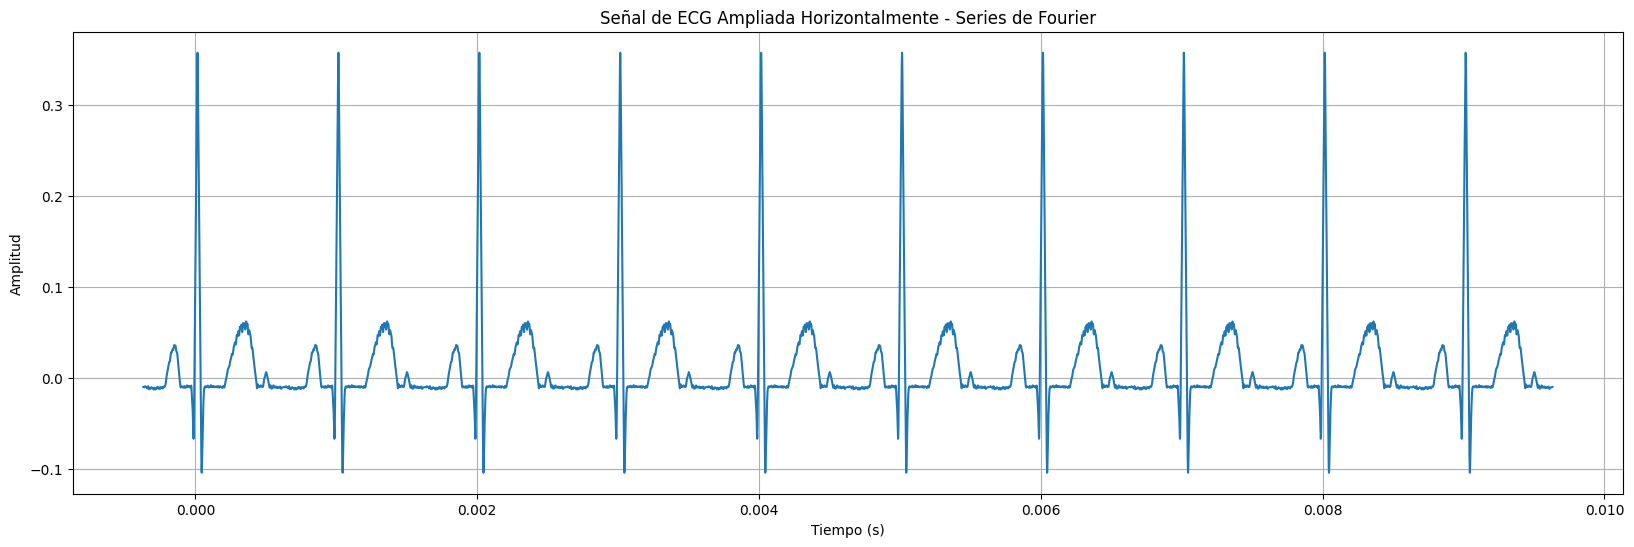

In [ ]:
# Graficar la señal reconstruida y ampliada
plt.figure(figsize=(20, 6))
plt.plot(x_amp, y_amp)
plt.title('Señal de ECG Ampliada Horizontalmente - Series de Fourier')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

### Serie de fourier

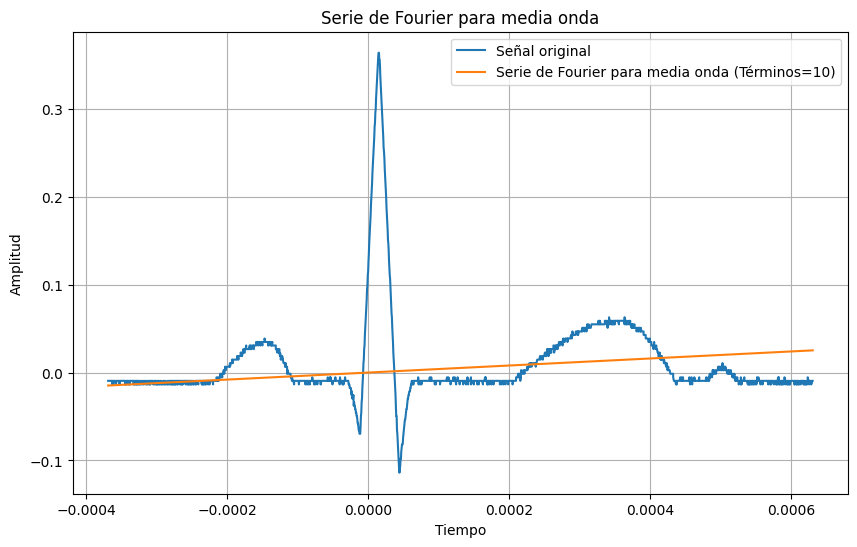

In [ ]:
x = df['x']
y = df['y']
num_terms = 10

gen_serfou_media(x, y, num_terms)

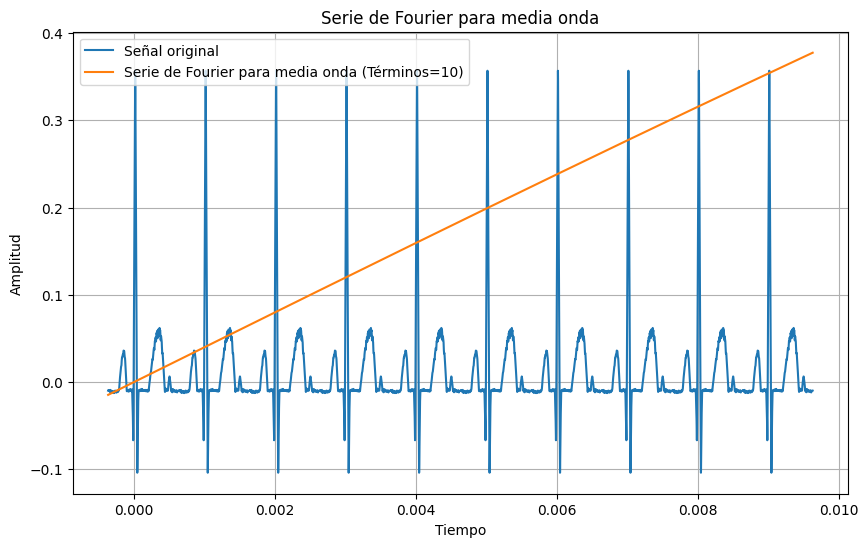

In [ ]:
x = x_amp
y = y_amp
num_terms = 10

gen_serfou_media(x, y, num_terms)

## Generacion por medio de funcion

In [ ]:
# Funcion que recibe parametros para la creacion de una señal ECG a partir de estos parametros
def gen_senal_ecg(duration, sampling_rate, p_wave_duration, p_wave_amplitude, pr_interval, qrs_duration, qrs_amplitude, qt_interval, t_wave_duration, u_wave_duration, pq_interval, heart_rate, amplitude_scale, t_pulse):
    # Definicion de datos para eje de tiempo
    tiempo = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)
    # Definicion de datos iniciales para eje de amplitud
    amplitud = np.zeros_like(tiempo)

    # Se generan los valores requeridos para formar la señal en base a los parametros proporcionados
    for i, time in enumerate(tiempo):
        t_instant = time % t_pulse
        if t_instant < p_wave_duration:
            amplitud[i] += p_wave_amplitude * np.sin((2 * np.pi * t_instant) / p_wave_duration)
        if t_instant >= pr_interval and t_instant < (pr_interval + qrs_duration):
            amplitud[i] += qrs_amplitude * np.sin((2 * np.pi * (t_instant - pr_interval)) / qrs_duration)
        if t_instant >= qt_interval:
            amplitud[i] -= 0.2 * np.sin((2 * np.pi * (t_instant - qt_interval)) / (0.5 * qt_interval))
        if t_instant >= (qt_interval + 0.04) and t_instant < (qt_interval + 0.04 + t_wave_duration):
            amplitud[i] += 0.15 * np.sin((2 * np.pi * (t_instant - qt_interval - 0.04)) / t_wave_duration)
        if t_instant >= (qt_interval + 0.1) and t_instant < (qt_interval + 0.1 + u_wave_duration):
            amplitud[i] += 0.1 * np.sin((2 * np.pi * (t_instant - qt_interval - 0.1)) / u_wave_duration)

    # Se amplia la escala de la señal obtenida para el eje amplitud en la escala proporcionada
    amplitud *= amplitude_scale
    # Se grafica la señal resultante
    plt.figure(figsize=(10, 5))
    plt.plot(tiempo, amplitud)
    plt.title('Señal ECG generada por funcion')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.show()

    return tiempo, amplitud

Explicacion de los parametros de una señal ECG:

* Duracion = Indica la duración total de la señal ECG en segundos.

* sampling_rate =  Es la frecuencia de muestreo de la señal ECG, medida en muestras por segundo (Hz).

* p_wave_duration = La duración de la onda P, que es la parte del ECG que representa la despolarización de los atrios del corazón.

* p_wave_amplitude = La amplitud de la onda P, que es la altura máxima alcanzada por la onda P en el ECG.

* pr_interval = El intervalo PR, que es el tiempo que transcurre entre el inicio de la onda P y el inicio del complejo QRS. Representa el tiempo que tarda la señal eléctrica en viajar desde los atrios hasta los ventrículos.

* qrs_duration = La duración del complejo QRS, que representa la despolarización de los ventrículos del corazón.

* qrs_amplitude = La amplitud del complejo QRS, que es la altura máxima alcanzada por el complejo QRS en el ECG.

* qt_interval = El intervalo QT, que es el tiempo entre el inicio de la despolarización ventricular (inicio del complejo QRS) y el final de la repolarización ventricular (final de la onda T).

* t_wave_duration = La duración de la onda T, que representa la repolarización de los ventrículos.

* u_wave_duration = La duración de la onda U, que es una pequeña onda que a veces aparece después de la onda T y que representa la repolarización de los músculos papilares.

* pq_interval = El intervalo PQ, también conocido como intervalo PR corregido. Es similar al intervalo PR, pero corregido para la frecuencia cardíaca.

* heart_rate = La frecuencia cardíaca en latidos por minuto.

* amplitude_scale = Un factor de escala que se aplica a la amplitud de toda la señal ECG.

* t_pulse = El período del pulso T, que es el tiempo entre dos pulsos T consecutivos. Se calcula dividiendo 60 por la frecuencia cardíaca para obtener el período en segundos.

In [ ]:
# Duracion en segundos
duracion = 10
# Frecuencia de muestras por segundo (Hz)
sampling_rate = 1000
# Duración de la onda P
p_wave_duration = 0.09
# Amplitud de la onda P
p_wave_amplitude = 0.8
# Intervalo PR
pr_interval = 0.2
# Duración del complejo QRS
qrs_duration = 0.14
# Amplitud del complejo QRS
qrs_amplitude = 3.2
# Intervalo QT
qt_interval = 0.5
# Duración de la onda T
t_wave_duration = 0.4
# Duración de la onda U
u_wave_duration = 0.4
# Intervalo PQ
pq_interval = 0.15
# Factor de escala para la señal
amplitude_scale = 1.5

Ahora bien, vamos a describir como el valor dado para el parametro de heart_rate se ajusta a una escala y significa algo medicamente.

* Rango Normal (60-100 latidos por minuto): Este es el rango típico para adultos en reposo.
Indica un corazón saludable y una buena capacidad cardiovascular.

* Bradicardia (Menos de 60 latidos por minuto):
Una frecuencia cardíaca más baja de lo normal.
Puede ser normal para personas en buena forma física o atletas entrenados.
En otros casos, puede indicar problemas de salud como hipotiroidismo, enfermedad del nodo sinusal o efectos secundarios de ciertos medicamentos.

* Taquicardia (Más de 100 latidos por minuto):
Una frecuencia cardíaca más alta de lo normal.
Puede ser causada por ejercicio, ansiedad, fiebre, deshidratación o consumo de cafeína.
En algunos casos, puede indicar problemas cardíacos subyacentes como arritmias, insuficiencia cardíaca, enfermedad de las arterias coronarias o trastornos de la tiroides.

### Persona con frecuencia normal


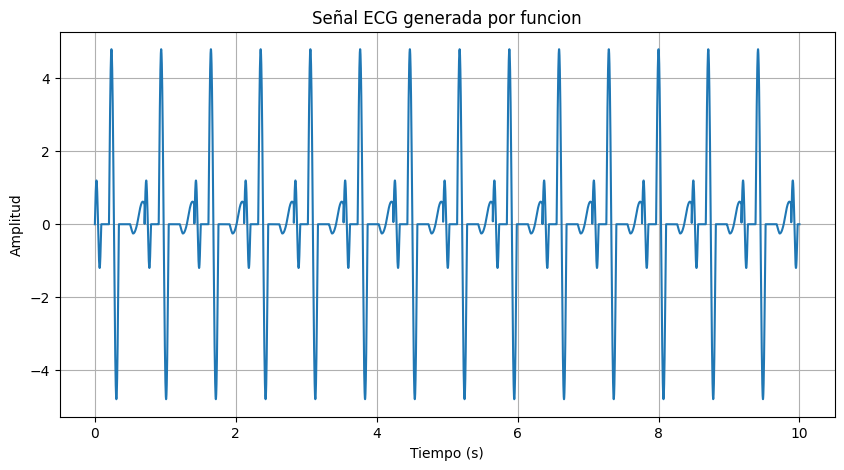

In [ ]:
# Frecuencia cardíaca "Normal" en adultos de latidos por minuto
heart_rate = 85
# Período del pulso T
t_pulse = 60 / heart_rate
# Generar señal ECG
tiempo_ecgnorm, amplitud_ecgnorm = gen_senal_ecg(duracion, sampling_rate, p_wave_duration, p_wave_amplitude, pr_interval, qrs_duration, qrs_amplitude, qt_interval, t_wave_duration, u_wave_duration, pq_interval, heart_rate, amplitude_scale, t_pulse)

### Persona con Bricardia

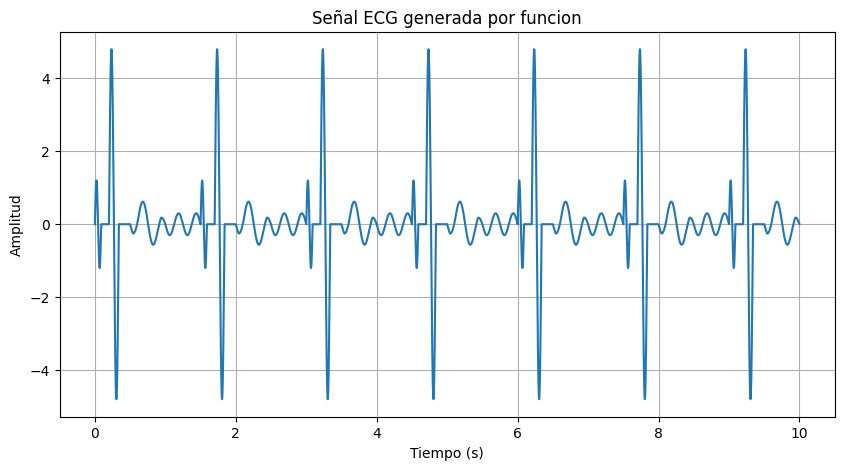

In [ ]:
# Frecuencia cardíaca "Bradicardia" de latidos por minuto
heart_rate = 40
# Período del pulso T
t_pulse = 60 / heart_rate
# Generar señal ECG
tiempo_ecgbri, amplitud_ecgbri = gen_senal_ecg(duracion, sampling_rate, p_wave_duration, p_wave_amplitude, pr_interval, qrs_duration, qrs_amplitude, qt_interval, t_wave_duration, u_wave_duration, pq_interval, heart_rate, amplitude_scale, t_pulse)

### Persona con Taquicardia

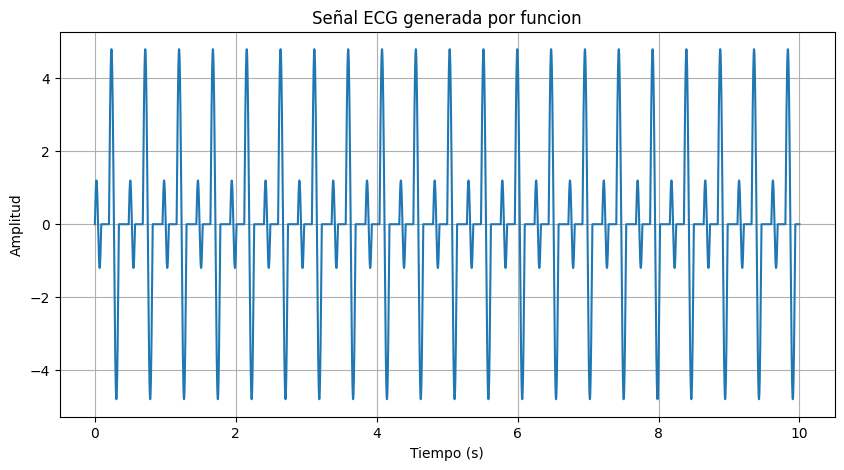

In [ ]:
# Frecuencia cardíaca "Taquicardia" de latidos por minuto
heart_rate = 125
# Período del pulso T
t_pulse = 60 / heart_rate
# Generar señal ECG
tiempo_ecgtaq, amplitud_ecgtaq = gen_senal_ecg(duracion, sampling_rate, p_wave_duration, p_wave_amplitude, pr_interval, qrs_duration, qrs_amplitude, qt_interval, t_wave_duration, u_wave_duration, pq_interval, heart_rate, amplitude_scale, t_pulse)

### Serie de fourier

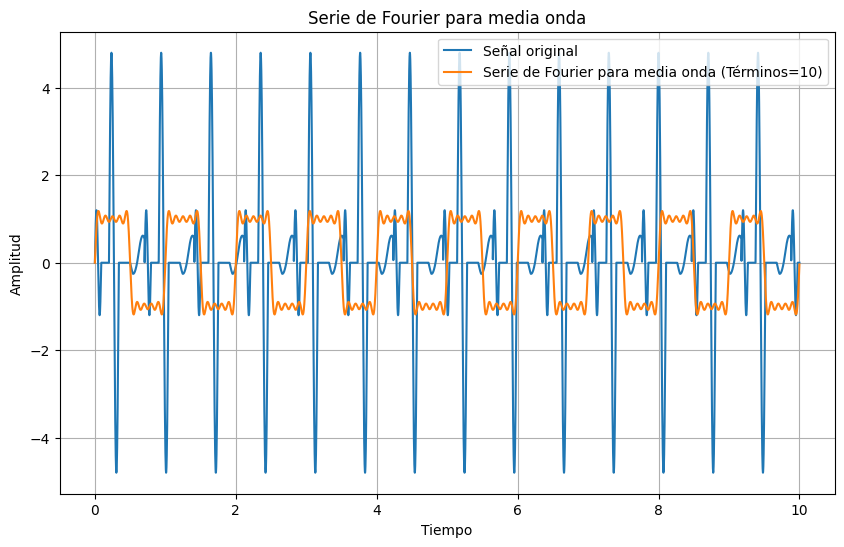

In [ ]:
x = tiempo_ecgnorm
y = amplitud_ecgnorm
num_terms = 10

gen_serfou_media(x, y, num_terms)

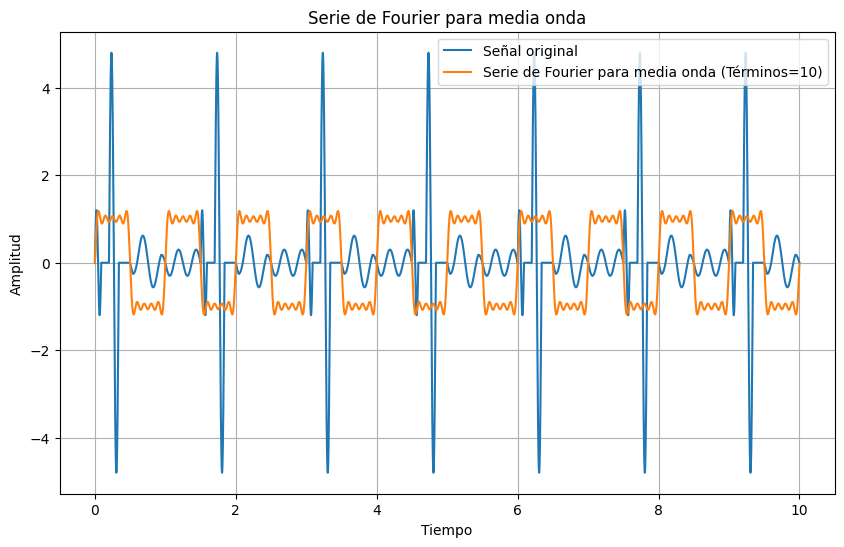

In [ ]:
x = tiempo_ecgbri
y = amplitud_ecgbri
num_terms = 10

gen_serfou_media(x, y, num_terms)

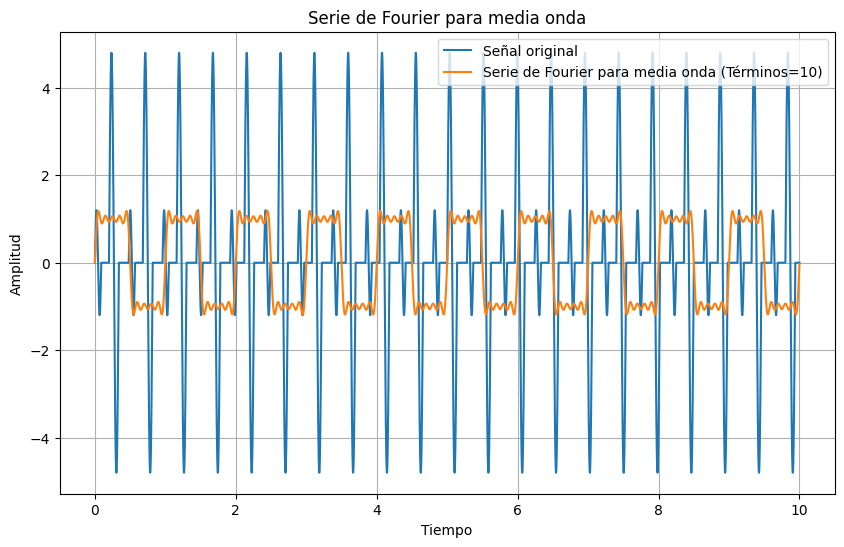

In [ ]:
x = tiempo_ecgtaq
y = amplitud_ecgtaq
num_terms = 10

gen_serfou_media(x, y, num_terms)

# Diseño de ECG persona enferma

Vamos a emplear datos extraidos de los dataset de la siguiente pagina:
https://www.kaggle.com/datasets/shayanfazeli/heartbeat

Mas especificamente, vamos a emplear el dataset de mitmitbih_train

Declaramos que mitmitbih_train va a funcionar como dataset de clasificacion entre Latidos normales, Latido cardíaco rápido o errático irregular (arritmia), Latido ectópicos ventriculares (latidos adicionales que comienzan en una de las dos cavidades inferiores de bombeo del corazón alterando el ritmo cardíaco regular provocando interrupciones de los latidos en el pecho), Latidos de fusión (Es cuando el ventrículo se activa al mismo tiempo por el latido sinusal y la extrasístole)
y Latidos desconocidos.


* Latidos Normales (Normales):
Estos son los latidos cardíacos típicos y regulares que ocurren en un corazón sano. Tienen una secuencia normal de activación eléctrica y se producen a un ritmo constante.
Arritmia: La arritmia se refiere a cualquier anomalía en el ritmo cardíaco, lo que significa que el corazón late demasiado rápido, demasiado lento o de manera irregular. Puede ser causada por varios factores, como problemas en el sistema eléctrico del corazón, enfermedades cardíacas, estrés, etc.

* Latidos Ectópicos (Extrasístoles):
Los latidos ectópicos son latidos cardíacos prematuros que ocurren fuera del ritmo normal. Pueden surgir de áreas del corazón distintas del nodo sinusal (el marcapasos natural del corazón), y pueden sentirse como una "palpitación" o "salto" en el pecho.

* Latidos de Fusión (Fusion Beats):
Los latidos de fusión son una combinación de latidos normales y latidos ectópicos. Ocurren cuando un latido ectópico y un latido normal se fusionan en uno solo en el electrocardiograma (ECG). Pueden ser más difíciles de identificar que los latidos ectópicos o los latidos normales por separado.

* Latidos Desconocidos (Unknown Beats):
En algunos casos, puede haber latidos cardíacos que no se pueden clasificar fácilmente en ninguna de las categorías anteriores debido a varias razones, como artefactos en el ECG, problemas de registro, etc.


La clasificación de los latidos cardíacos es fundamental en el diagnóstico de trastornos cardíacos y en la monitorización de la salud cardíaca de los pacientes. Herramientas como el análisis de señales de ECG y algoritmos de aprendizaje automático se utilizan comúnmente para automatizar este proceso y ayudar a los médicos a identificar patrones anormales en el ritmo cardíaco de manera más eficiente.

## Importación de datos

In [ ]:
# URL del archivo CSV
url_clasificar = "/content/mitbih_train.csv"
#url_sano = "/content/ptbdb_normal.csv"

# Cargar los datos en DataFrames
df_clasificar = pd.read_csv(url_clasificar, header=None)
#df_sano = pd.read_csv(url_sano, header=None)

In [ ]:
# Visualizamos el dataset de pacientes sanos
#df_sano

In [ ]:
#num_filas = df_sano.shape[0]
#print("El número de filas en df_sano es:", num_filas)

In [ ]:
# Visualizamos el dataset de pacientes clasificantes
df_clasificar

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [ ]:
num_filas = df_clasificar.shape[0]
print("El número de filas en df_clasificar es:", num_filas)

El número de filas en df_clasificar es: 87554


Podemos determinar que cada paciente esa representado por cada fila de los datasets.

Podemos decir que el dataset de pacientes sanos cuenta con 4046 pacientes. Mientras el dataset de pacientes clasificantes cuenta con 87554 pacientes.


## Limpieza de datos

Si existen datos nulos en los datasets importados, son eliminados para el correcto tratamiento de los datos más adelante.

In [ ]:
df_clasificar = df_clasificar.dropna()
#df_sano = df_sano.dropna()

## Analizar datos

In [ ]:
# Mostrar ultima columna del dataset de df_clasificar
df_clasificar.iloc[:, -1]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
87549    4.0
87550    4.0
87551    4.0
87552    4.0
87553    4.0
Name: 187, Length: 87554, dtype: float64

Esta ultima columna correspone a la clasificacion del paciente, entre latidos normales, arritmia, latidos ecotopicos, latidos de fusion y latidos desconocidos.

In [ ]:
# Contar cuantas veces aparece cada categoria de latidos de corazon
df_clasificar.iloc[:, -1] = df_clasificar.iloc[:, -1].astype(int)
categorias = df_clasificar.iloc[:, -1].value_counts()
categorias

<ipython-input-344-70a6ebae4f4f>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_clasificar.iloc[:, -1] = df_clasificar.iloc[:, -1].astype(int)


0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64

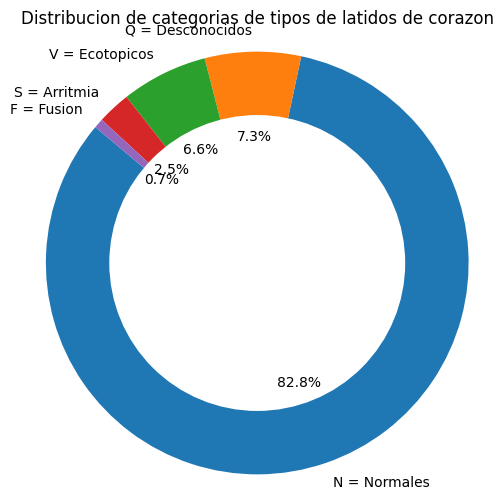

In [ ]:
# Labels correspondientes a los tipos de latidos
labels = ['N = Normales', 'Q = Desconocidos', 'V = Ecotopicos', 'S = Arritmia', 'F = Fusion']

# Configuración del gráfico de círculo
plt.figure(figsize=(6, 6))
plt.pie(categorias, labels=labels, autopct='%1.1f%%', startangle=140)

# Añadir un círculo en el centro para que parezca un donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Ajustar aspectos visuales
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Mostrar el gráfico
plt.title('Distribucion de categorias de tipos de latidos de corazon')
plt.show()

Vamos a separar cada tipo de paciente y tipo de latido en diferentes listas

In [ ]:
pacientes_clas_0 = []  # Lista para pacientes clasificados como 0
pacientes_clas_1 = []  # Lista para pacientes clasificados como 1
pacientes_clas_2 = []  # Lista para pacientes clasificados como 2
pacientes_clas_3 = []  # Lista para pacientes clasificados como 3
pacientes_clas_4 = []  # Lista para pacientes clasificados como 4

for indice, fila in df_clasificar.iterrows():
    clasificacion = fila.iloc[-1]  # Obtener la clasificación de la última columna
    if clasificacion == 0:
        pacientes_clas_0.append((indice, fila))  # Guardar el índice y la fila para clasificación 0
    elif clasificacion == 1:
        pacientes_clas_1.append((indice, fila))  # Guardar el índice y la fila para clasificación 1
    elif clasificacion == 2:
        pacientes_clas_2.append((indice, fila))  # Guardar el índice y la fila para clasificación 2
    elif clasificacion == 3:
        pacientes_clas_3.append((indice, fila))  # Guardar el índice y la fila para clasificación 3
    elif clasificacion == 4:
        pacientes_clas_4.append((indice, fila))  # Guardar el índice y la fila para clasificación 4

## Graficas

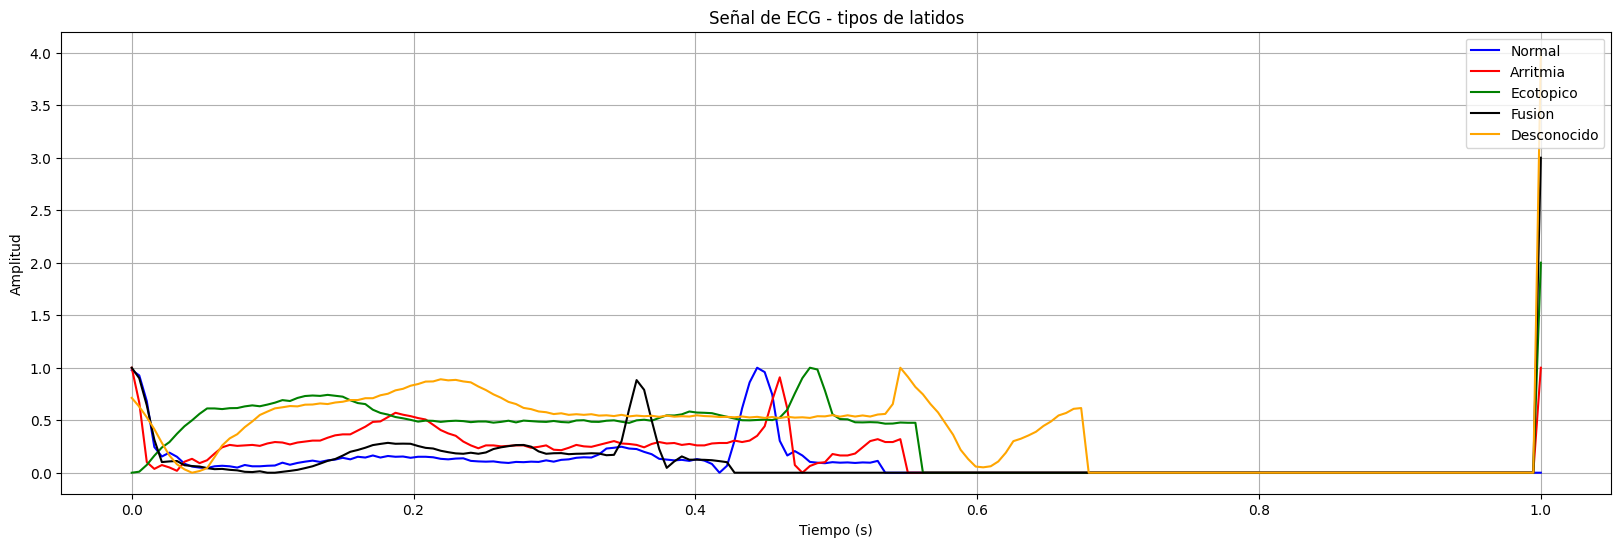

In [ ]:
# Dibujar la señal ECG ampliada
plt.figure(figsize=(20, 6))
plt.plot(np.linspace(0, 1, len(pacientes_clas_0[0][1])), pacientes_clas_0[0][1], c='b', label='Normal')
plt.plot(np.linspace(0, 1, len(pacientes_clas_1[0][1])), pacientes_clas_1[0][1], c='r', label='Arritmia')
plt.plot(np.linspace(0, 1, len(pacientes_clas_2[0][1])), pacientes_clas_2[0][1], c='g', label='Ecotopico')
plt.plot(np.linspace(0, 1, len(pacientes_clas_3[0][1])), pacientes_clas_3[0][1], c='black', label='Fusion')
plt.plot(np.linspace(0, 1, len(pacientes_clas_4[0][1])), pacientes_clas_4[0][1], c='orange', label='Desconocido')
plt.title('Señal de ECG - tipos de latidos')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Insercion de señales

### Normal vs Arritmia

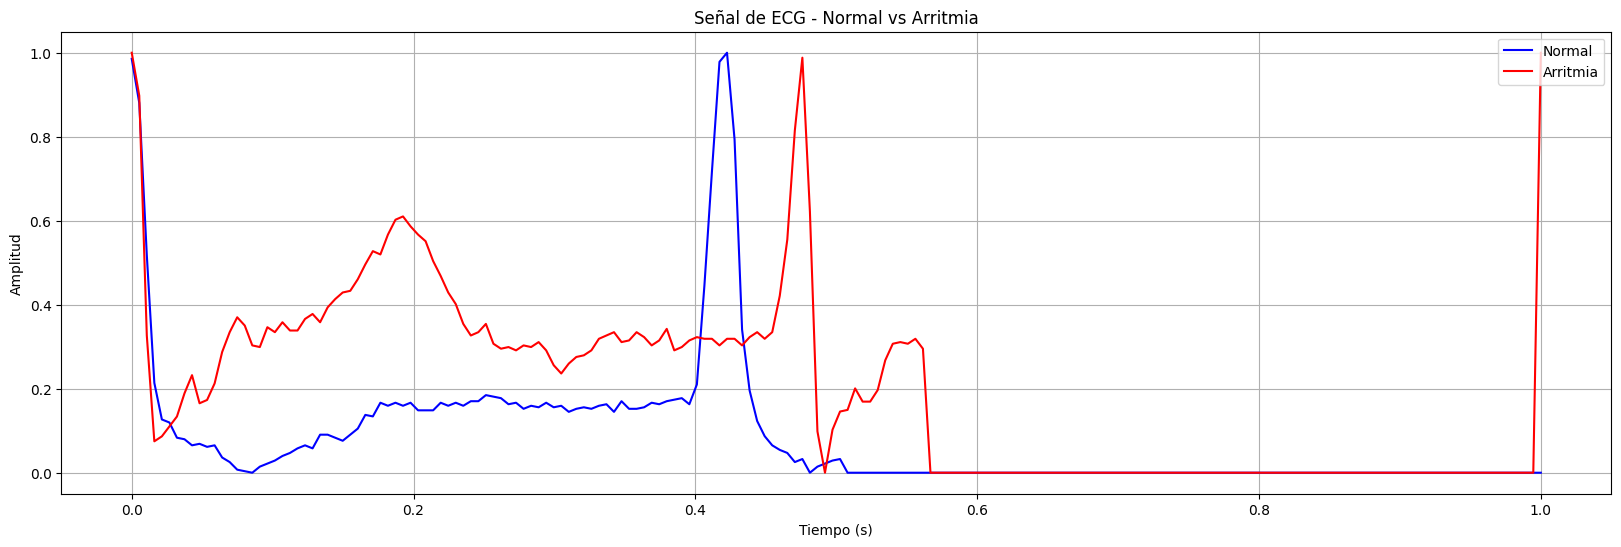

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(np.linspace(0, 1, len(pacientes_clas_0[10][1])), pacientes_clas_0[10][1], c='b', label='Normal')
plt.plot(np.linspace(0, 1, len(pacientes_clas_1[10][1])), pacientes_clas_1[10][1], c='r', label='Arritmia')
plt.title('Señal de ECG - Normal vs Arritmia')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

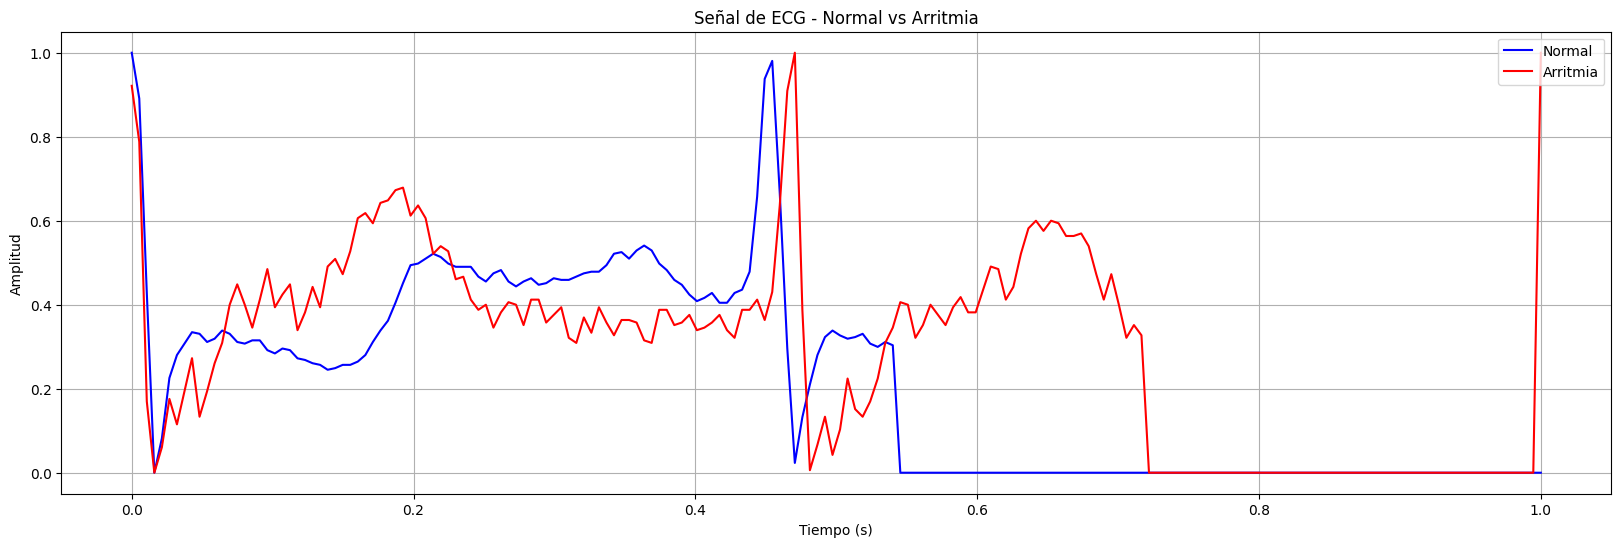

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(np.linspace(0, 1, len(pacientes_clas_0[30][1])), pacientes_clas_0[30][1], c='b', label='Normal')
plt.plot(np.linspace(0, 1, len(pacientes_clas_1[30][1])), pacientes_clas_1[30][1], c='r', label='Arritmia')
plt.title('Señal de ECG - Normal vs Arritmia')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

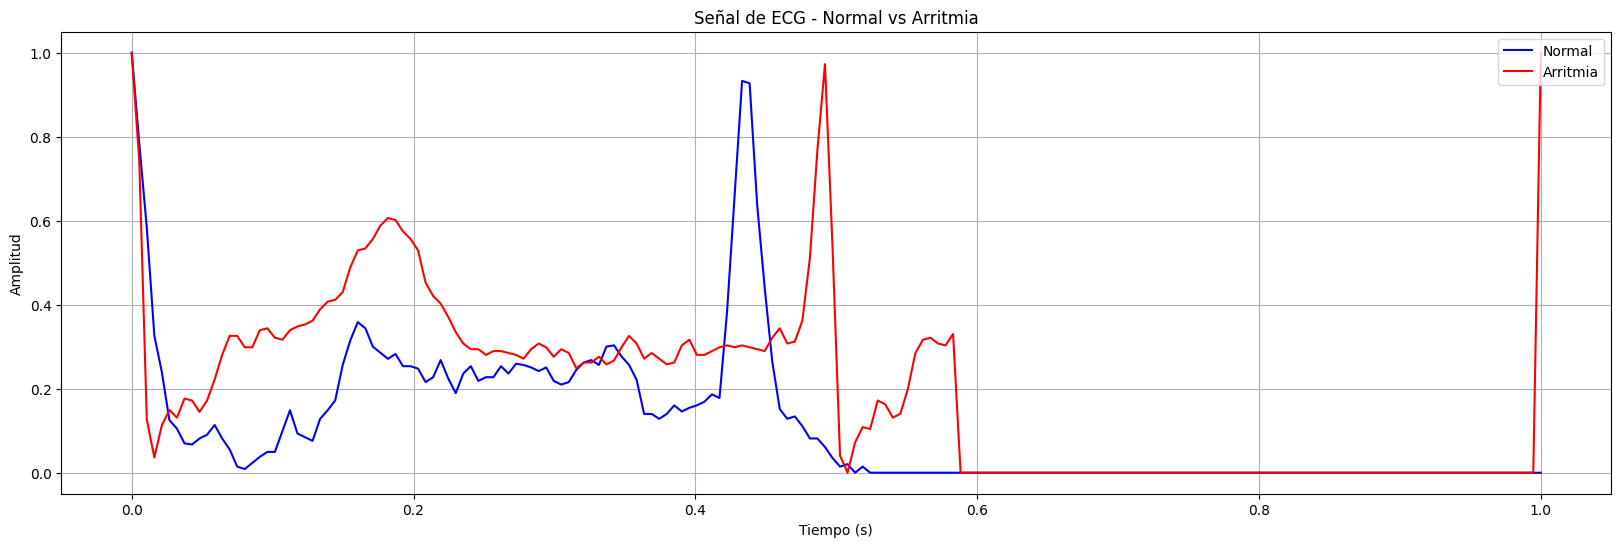

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(np.linspace(0, 1, len(pacientes_clas_0[50][1])), pacientes_clas_0[50][1], c='b', label='Normal')
plt.plot(np.linspace(0, 1, len(pacientes_clas_1[50][1])), pacientes_clas_1[50][1], c='r', label='Arritmia')
plt.title('Señal de ECG - Normal vs Arritmia')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Normal vs Ecotopico

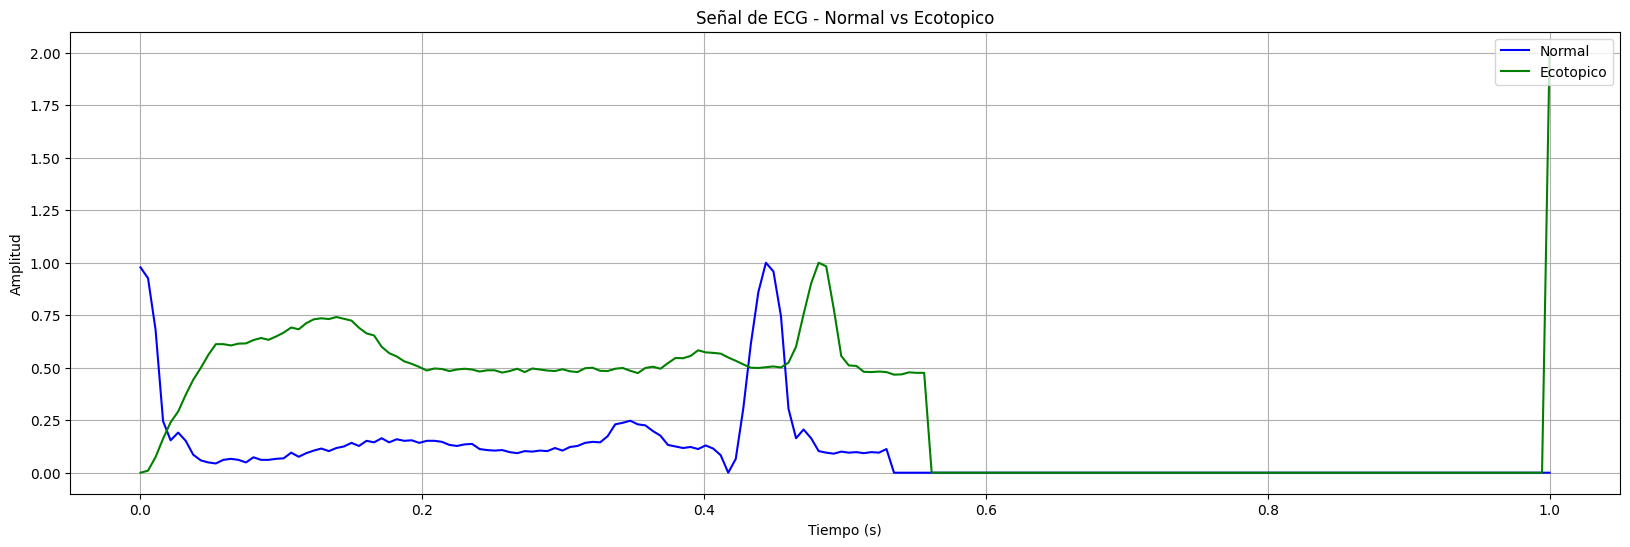

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(np.linspace(0, 1, len(pacientes_clas_0[0][1])), pacientes_clas_0[0][1], c='b', label='Normal')
plt.plot(np.linspace(0, 1, len(pacientes_clas_2[0][1])), pacientes_clas_2[0][1], c='g', label='Ecotopico')
plt.title('Señal de ECG - Normal vs Ecotopico')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

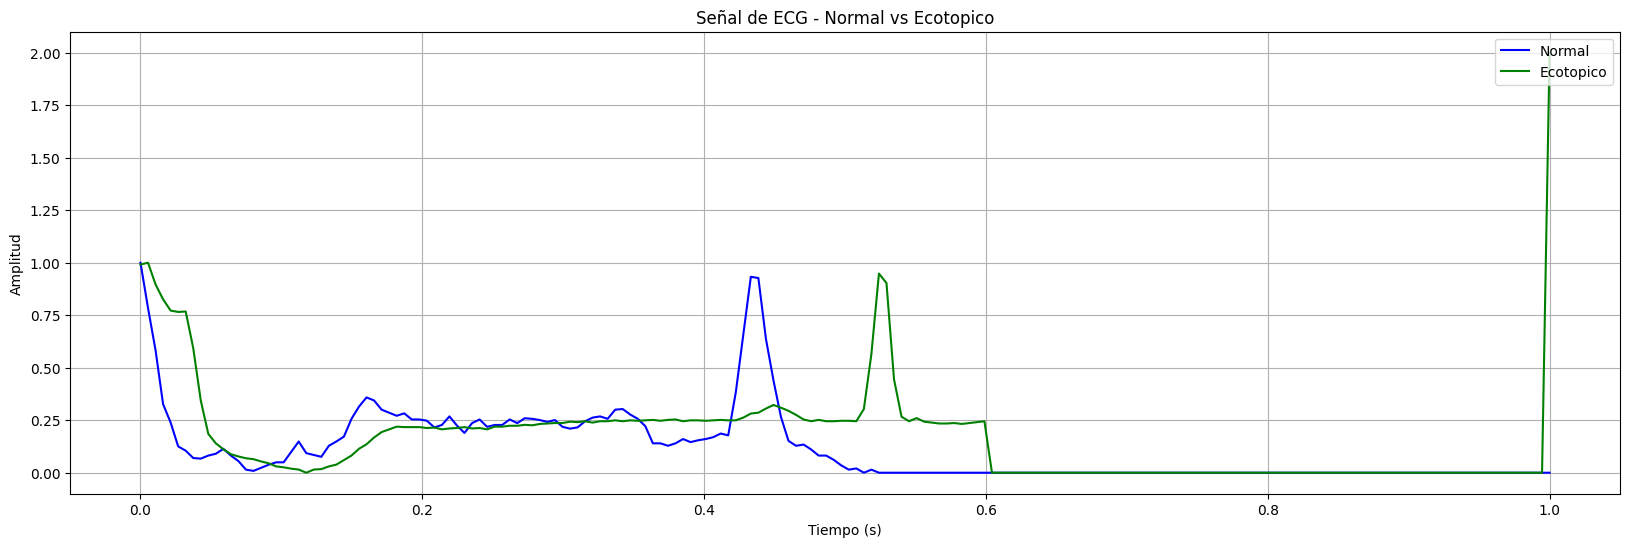

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(np.linspace(0, 1, len(pacientes_clas_0[50][1])), pacientes_clas_0[50][1], c='b', label='Normal')
plt.plot(np.linspace(0, 1, len(pacientes_clas_2[50][1])), pacientes_clas_2[50][1], c='g', label='Ecotopico')
plt.title('Señal de ECG - Normal vs Ecotopico')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Normal vs Fusion

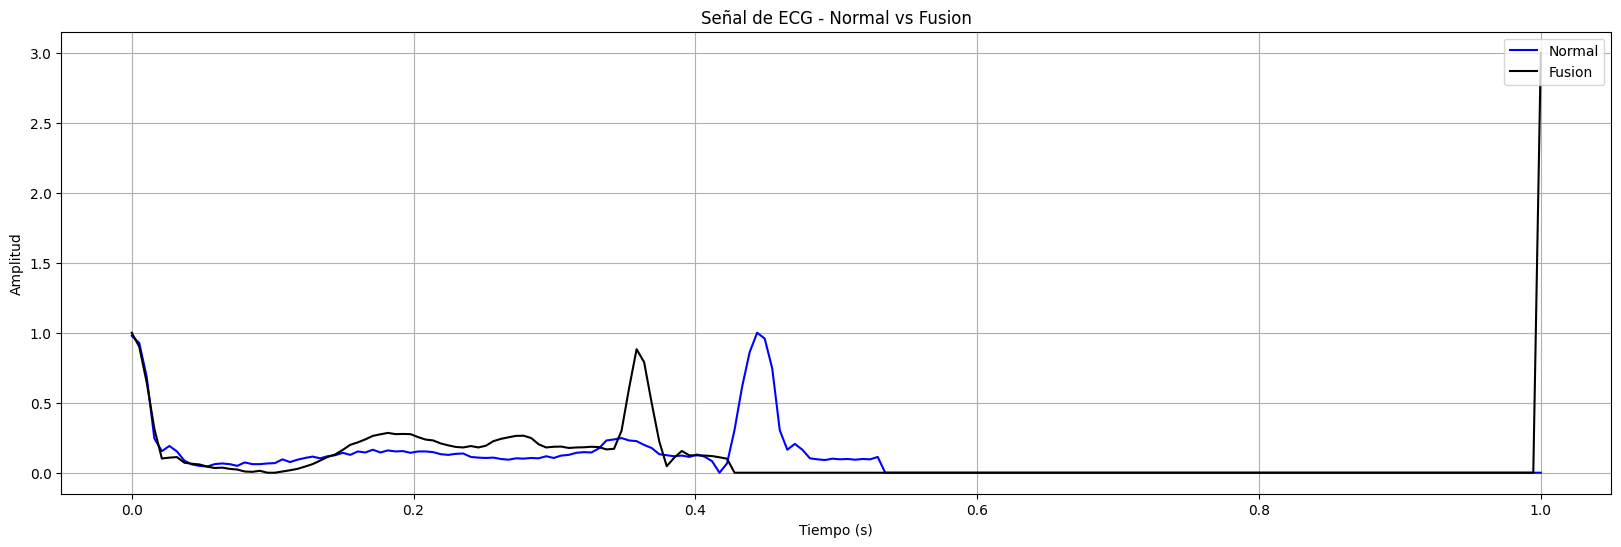

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(np.linspace(0, 1, len(pacientes_clas_0[0][1])), pacientes_clas_0[0][1], c='b', label='Normal')
plt.plot(np.linspace(0, 1, len(pacientes_clas_3[0][1])), pacientes_clas_3[0][1], c='black', label='Fusion')
plt.title('Señal de ECG - Normal vs Fusion')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

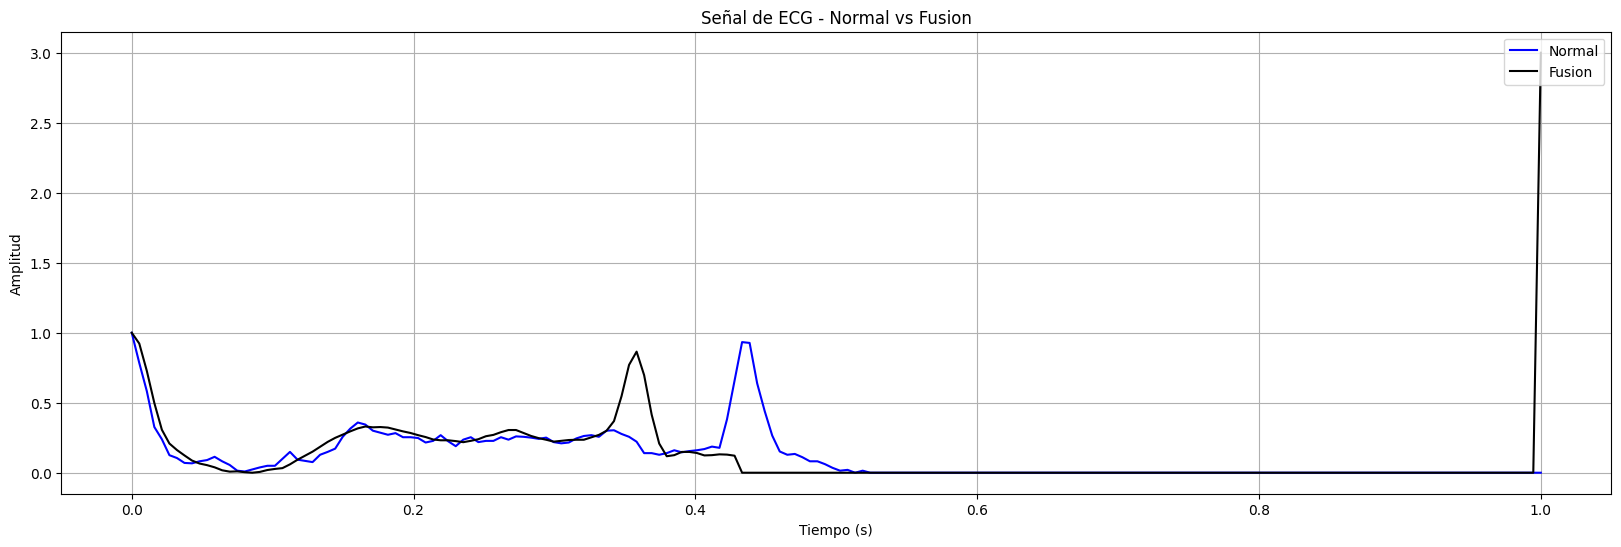

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(np.linspace(0, 1, len(pacientes_clas_0[50][1])), pacientes_clas_0[50][1], c='b', label='Normal')
plt.plot(np.linspace(0, 1, len(pacientes_clas_3[50][1])), pacientes_clas_3[50][1], c='black', label='Fusion')
plt.title('Señal de ECG - Normal vs Fusion')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Normal vs Desconocido

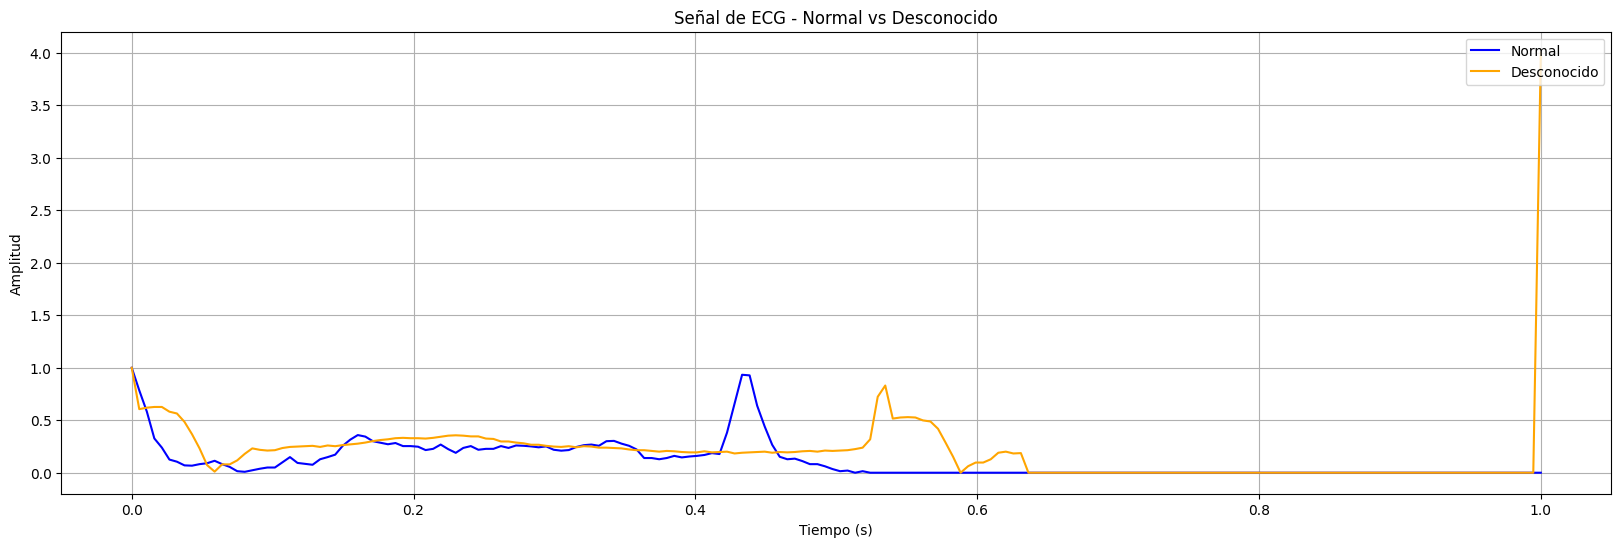

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(np.linspace(0, 1, len(pacientes_clas_0[50][1])), pacientes_clas_0[50][1], c='b', label='Normal')
plt.plot(np.linspace(0, 1, len(pacientes_clas_4[50][1])), pacientes_clas_4[50][1], c='orange', label='Desconocido')
plt.title('Señal de ECG - Normal vs Desconocido')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

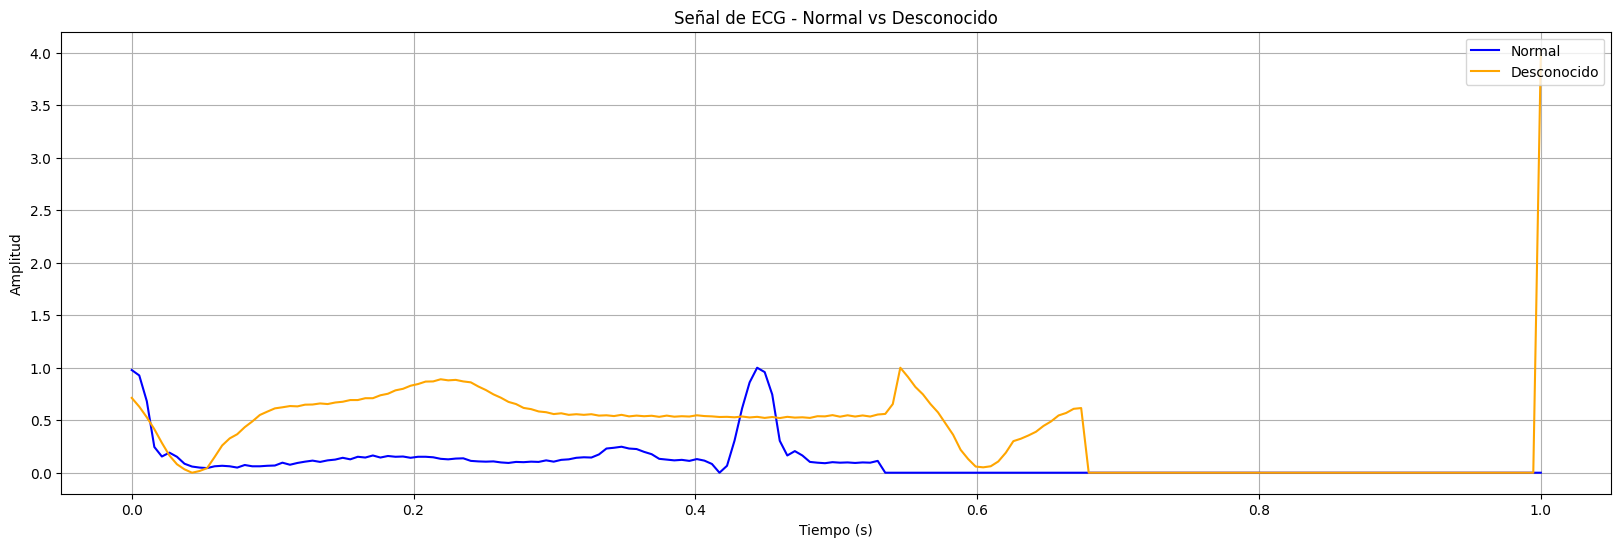

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(np.linspace(0, 1, len(pacientes_clas_0[0][1])), pacientes_clas_0[0][1], c='b', label='Normal')
plt.plot(np.linspace(0, 1, len(pacientes_clas_4[0][1])), pacientes_clas_4[0][1], c='orange', label='Desconocido')
plt.title('Señal de ECG - Normal vs Desconocido')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Analisis de las graficas

# Modelo de clasificasion

In [ ]:
url_test = "/content/mitbih_test.csv"
df_test = pd.read_csv(url_test, header=None)

In [ ]:
# Separar características (X) y etiquetas (y) en los conjuntos de entrenamiento y prueba
X_train = df_clasificar.iloc[:, :-1]  # Todas las columnas excepto la última
y_train = df_clasificar.iloc[:, -1]   # Última columna que contiene los clasificadores

X_test = df_test.iloc[:, :-1]  # Todas las columnas excepto la última
y_test = df_test.iloc[:, -1]   # Última columna que contiene los clasificadores

# Crear un modelo de clasificación (puedes utilizar otro modelo según tus necesidades)
clf = RandomForestClassifier()

# Entrenar el modelo
clf.fit(X_train, y_train)

# Predecir las clasificaciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Evaluar el rendimiento del modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     18118
         1.0       0.98      0.60      0.74       556
         2.0       0.98      0.88      0.93      1448
         3.0       0.88      0.61      0.72       162
         4.0       1.00      0.94      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.96      0.81      0.87     21892
weighted avg       0.97      0.97      0.97     21892



In [ ]:
# Predicciones
y_pred

array([0, 0, 0, ..., 4, 4, 4])

In [ ]:
np.where(y_pred == 1)[0][0]

991

In [ ]:
np.where(y_pred == 2)[0][0]

345

In [ ]:
np.where(y_pred == 3)[0][0]

18844

In [ ]:
np.where(y_pred == 4)[0][0]

6149

In [ ]:
def clasificar(tipo):
  print("\nDiagnostico:")
  if tipo == 0:
    print("--> El paciente tiene latidos normales")
  elif tipo == 1:
    print("--> El paciente tiene latidos arritmicos")
  elif tipo == 2:
    print("--> El paciente tiene latidos ecotopicos")
  elif tipo == 3:
    print("--> El paciente tiene latidos de tipo fusion")
  elif tipo == 4:
    print("--> El paciente tiene latidos desconocidos")

In [ ]:
def graf_ecg(paciente, tipo):
  plt.figure(figsize=(20, 6))
  if tipo == 0:
    plt.plot(np.linspace(0, 1, len(paciente)), paciente, c='b', label='Latidos normales')
  elif tipo == 1:
    plt.plot(np.linspace(0, 1, len(paciente)), paciente, c='r', label='Latidos arritmia')
  elif tipo == 2:
    plt.plot(np.linspace(0, 1, len(paciente)), paciente, c='g', label='Latidos ecotopico')
  elif tipo == 3:
    plt.plot(np.linspace(0, 1, len(paciente)), paciente, c='black', label='Latidos fusion')
  elif tipo == 4:
    plt.plot(np.linspace(0, 1, len(paciente)), paciente, c='orange', label='Latidos desconocidos')
  plt.title('Señal de ECG')
  plt.xlabel('Tiempo (s)')
  plt.ylabel('Amplitud')
  plt.legend(loc='upper right')
  plt.grid(True)
  plt.show()

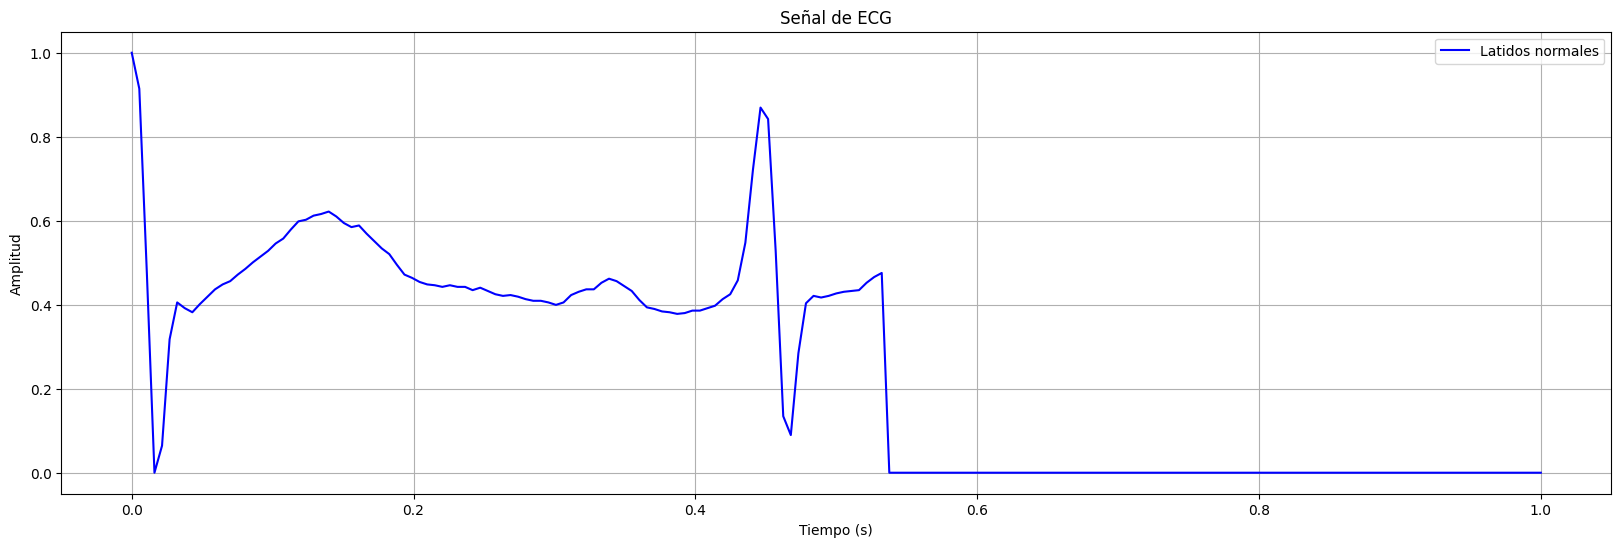


Diagnostico:
--> El paciente tiene latidos normales


In [ ]:
paciente_1 = df_test.iloc[10 - 1, :-1]
prediccion = clf.predict([paciente_1])
graf_ecg(paciente_1, prediccion)
clasificar(prediccion)

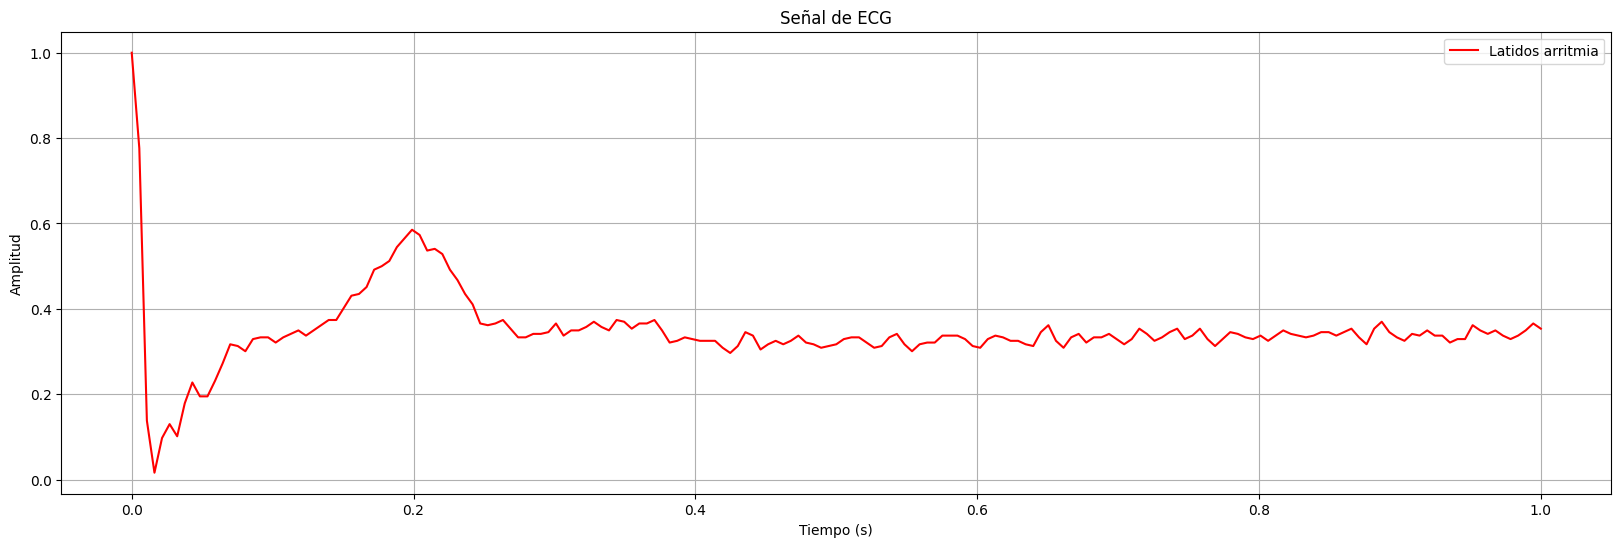


Diagnostico:
--> El paciente tiene latidos arritmicos


In [ ]:
paciente_2 = df_test.iloc[992 - 1, :-1]
prediccion = clf.predict([paciente_2])
graf_ecg(paciente_2, prediccion)
clasificar(prediccion)

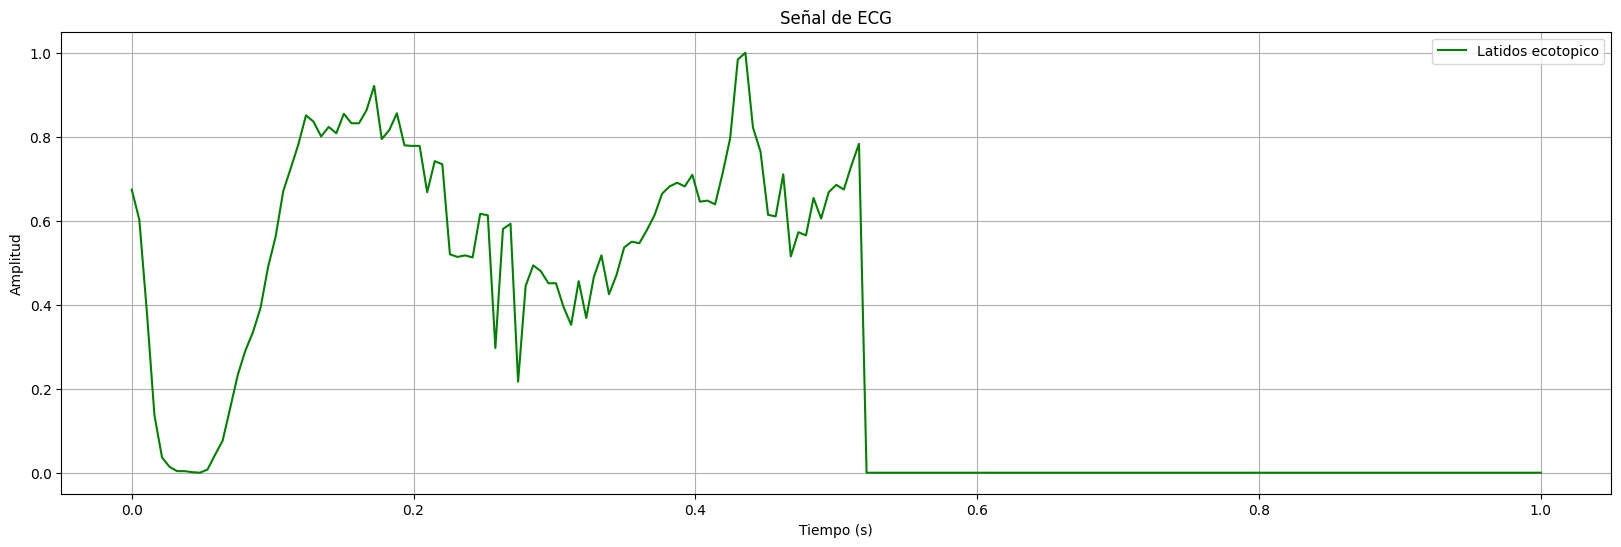


Diagnostico:
--> El paciente tiene latidos ecotopicos


In [ ]:
paciente_3 = df_test.iloc[346 - 1, :-1]
prediccion = clf.predict([paciente_3])
graf_ecg(paciente_3, prediccion)
clasificar(prediccion)

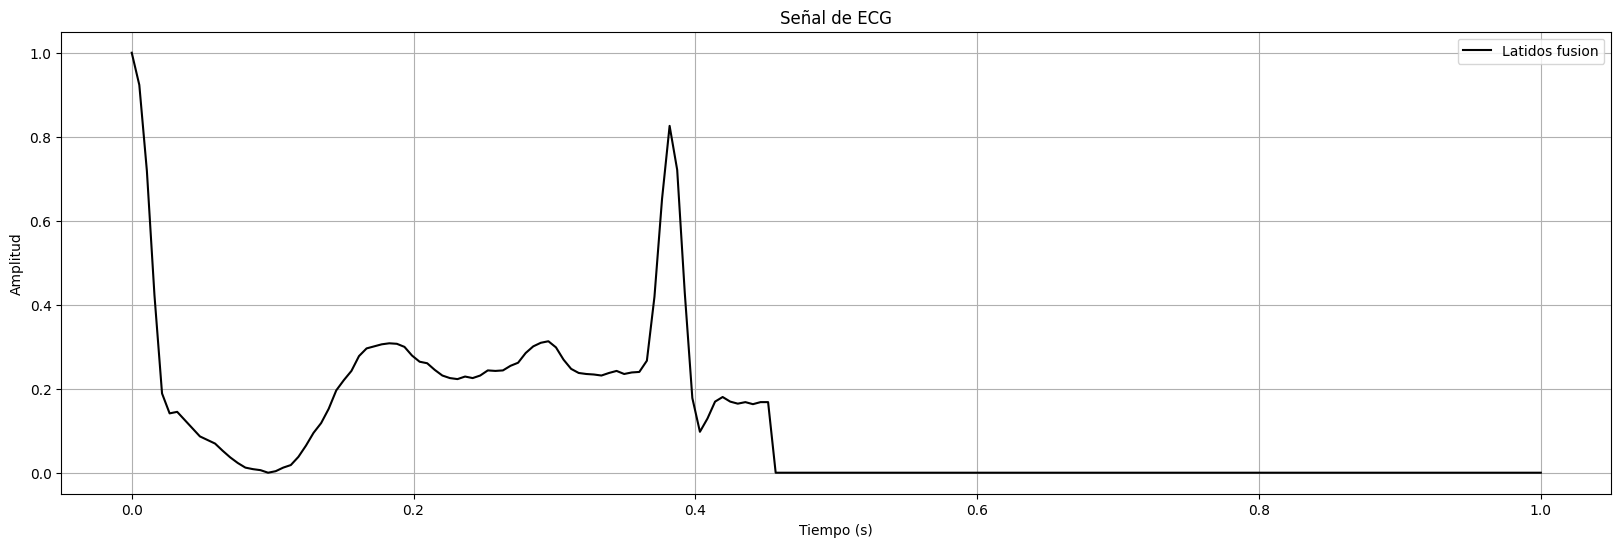


Diagnostico:
--> El paciente tiene latidos de tipo fusion


In [ ]:
paciente_4 = df_test.iloc[18845 - 1, :-1]
prediccion = clf.predict([paciente_4])
graf_ecg(paciente_4, prediccion)
clasificar(prediccion)

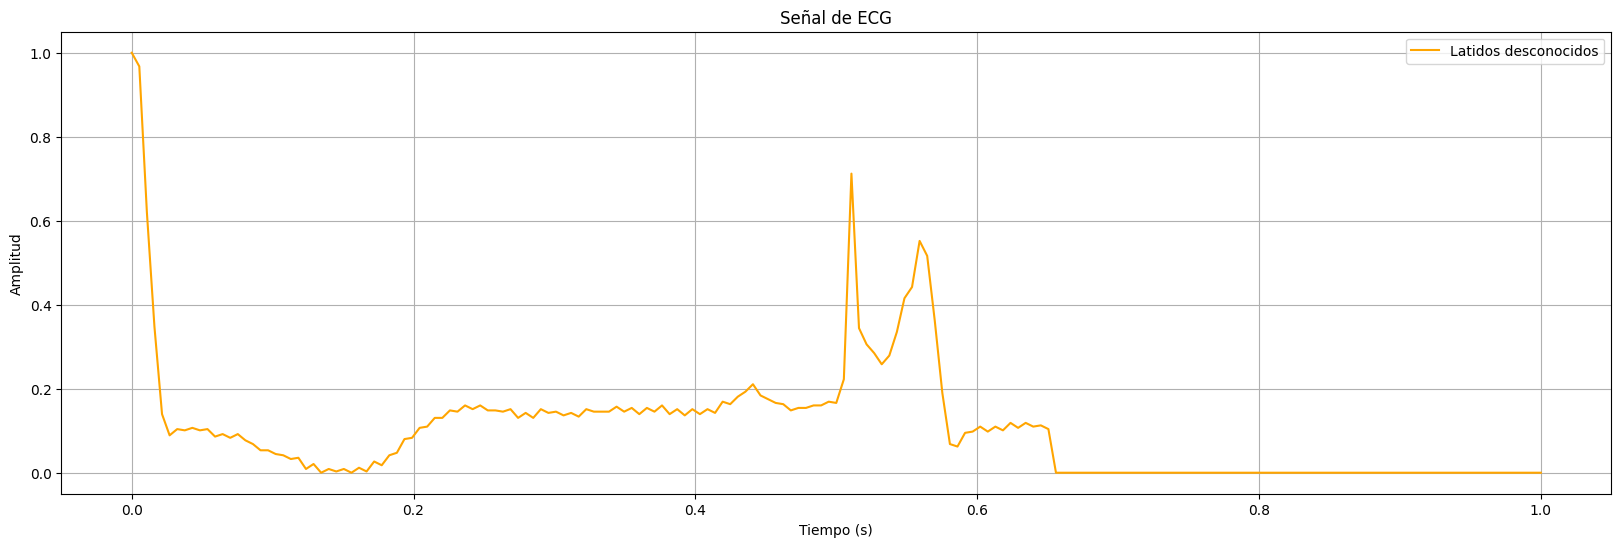


Diagnostico:
--> El paciente tiene latidos desconocidos


In [ ]:
paciente_5 = df_test.iloc[21890 - 1, :-1]
prediccion = clf.predict([paciente_5])
graf_ecg(paciente_5, prediccion)
clasificar(prediccion)